In [114]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
from torch import vmap
import caustics
from IPython.display import HTML
from matplotlib.colors import LogNorm
import corner

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
! python --version #VS code label wrong. Need <3.11 for mcmc in pylima

Python 3.10.14


In [116]:
cosmology = caustics.FlatLambdaCDM()
sie = caustics.Point(cosmology=cosmology, name='lens')
# src = caustics.Sersic(name='source')
src = caustics.PointSource(name='source')

In [117]:
n_pix = 100
res = 0.05
upsample_factor = 10
theta_x, theta_y = caustics.utils.meshgrid(
    res / upsample_factor,
    upsample_factor * n_pix,
    dtype=torch.float32,
)

In [125]:
class Microlens(caustics.Simulator):
    def __init__(
            self,
            lens,
            src,
            theta_x=None,
            theta_y=None,
            z_s=None,
            name: str = "sim"
    ):
        super().__init__(name)
        self.lens = lens
        self.src = src

        self.add_param("theta_x", theta_x)
        self.add_param('theta_y', theta_y)
        self.add_param("z_s", z_s)

    def forward(self, params):
        theta_x, theta_y, z_s = self.unpack(params)
        beta_x, beta_y = self.lens.raytrace(theta_x, theta_y, z_s, params)
        brightness = self.src.brightness(beta_x, beta_y, params)
        baseline_brightness = self.src.brightness(theta_x, theta_y, params) 
        return brightness, brightness.mean()/baseline_brightness.mean()

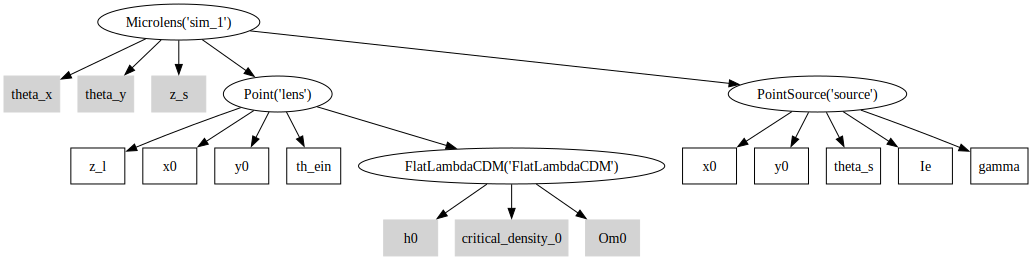

In [126]:
sim = Microlens(sie, src, theta_x=theta_x, theta_y=theta_y, z_s=0.0)
sim.graph(True,True)

In [127]:
sim.x_order

['lens.z_l',
 'lens.x0',
 'lens.y0',
 'lens.th_ein',
 'source.x0',
 'source.y0',
 'source.theta_s',
 'source.Ie',
 'source.gamma']

In [252]:
# Microlensing Model Parameters

u0 = 0.4 # minimum impact parameter (u(t=t_0))
t0 = 0.2 # time at peak magnification
tE = 0.1 # Einstein timescale

# Microlensing Physical Parameters
th_ein = 0.5 # Einstein radius in arcsec
rho = 2.0 # source size in Lens Einstein radii

In [213]:
B=64 #Batch size
ts = torch.linspace(-2*tE+t0,2*tE+t0,B).view(-1,1) #Create time grid

# calculate source position at each time
x0s = (ts-t0) / tE # Shape is [B, 1]

# Since source is assumed radially symmetric, can set all motion in the x direction
y0s = -u0 * torch.ones_like(x0s) 

In [338]:
# todo calculate t_e and express everything in terms of physical microlensing parameters
x = torch.tensor([
    #    z_l  x0   y0  th_ein x0   y0  theta_s,  Ie,    gamma
         0.0, 0.0, 0.0, 0.5, 0.0, 0.0, th_ein*rho, 5.0, 0.5 #Parametrize theta_s in terms of rho
        #  0.0, 0.0, 0.0, 0.5, 0.0, 0.0, th_ein*rho, 5.0, 0.0 #Parametrize theta_s in terms of rho

    ])  

newx = x.repeat(B, 1)
newx[:,1] = x0s.view(-1)
newx[:,2] = y0s.view(-1)

In [339]:
images, magnifications = torch.vmap(sim)(newx) 

In [340]:
# Set up the figure and two subplots
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6, 8))

# Display the first frame of the image in the first subplot
img = ax1.imshow(images[0].numpy(), cmap='cividis', interpolation='bilinear')
ax1.set_title('Image')

# Set up the scatter plot for magnifications in the second subplot
scatter = ax2.scatter(ts[0].item(), magnifications[0].item())
ax2.set_xlim(ts.min().item(), ts.max().item())
ax2.set_ylim(magnifications.min().item()*0.9, magnifications.max().item()*1.1)
ax2.axvline(-tE/2, color='r', linestyle='--')
ax2.axvline(tE/2, color='r', linestyle='--')
ax2.set_xlabel('t')
ax2.set_ylabel('A')

def update(frame):
    """Update function for the animation."""
    # Update the image in the first subplot
    img.set_array(images[frame].numpy())

    # Update the scatter plot in the second subplot
    ax2.clear()  # Clear the previous frame
    ax2.scatter(ts[:frame+1].numpy(), magnifications[:frame+1].numpy())
    ax2.set_xlim(ts.min().item(), ts.max().item())
    ax2.set_ylim(magnifications.min().item()*0.9, magnifications.max().item()*1.1)
    ax2.axvline(-tE+t0, color='r', linestyle='--')
    ax2.axvline(tE+t0, color='r', linestyle='--')
    ax2.set_xlabel('t')
    ax2.set_ylabel('A')
    ax2.set_title('Light-Curve')

    return img, scatter

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=B, interval=60)

plt.close()

#Save animation
# ani.save("microlensing_animation.gif", writer='pillow', fps=16)  # Adjust 'fps' for the speed

# Display the animation inline
HTML(ani.to_jshtml())

### Fitting the data

In [265]:
from pyLIMA import event
from pyLIMA import telescopes
from pyLIMA.models import PSPL_model, FSPLarge_model, FSPL_model
from pyLIMA.outputs import pyLIMA_plots
from pyLIMA.fits import LM_fit, TRF_fit, DE_fit, MCMC_fit
import numpy as np

In [266]:
noise = 0.02*torch.randn_like(magnifications)
noisy_mags = magnifications + noise
# data = np.vstack((ts.view(-1), -1*magnifications, magnifications*0.05)).T
err_mag = 0.05*torch.ones_like(magnifications) #set fixed error for now
data = np.vstack((ts.view(-1), -1*noisy_mags, err_mag)).T

In [267]:
# np.savez('microlensing_dat', data=data)
# data_test = np.load('microlensing_dat.npz')['data']

In [307]:
your_event = event.Event()
pspl_event = event.Event() #todo add pspl fit?
your_event.name = 'Simulated Event'
telescope = telescopes.Telescope(name= 'test', light_curve=data, light_curve_names=['time', 'mag', 'err_mag'], light_curve_units=['s', 'mag', 'err_mag'])
# telescope_pspl = telescopes.Telescope(name= 'test', light_curve=data, light_curve_names=['time', 'mag', 'err_mag'], light_curve_units=['s', 'mag', 'err_mag'])

your_event.telescopes.append(telescope)
# your_event.telescopes[0].ld_gamma = 0.5 ! Not working yet
your_event.find_survey('test')
your_event.check_event()


# pspl = PSPL_model.PSPLmodel(your_event)
fspl = FSPLarge_model.FSPLargemodel(your_event)
# fspl = FSPL_model.FSPLmodel(your_event)
# pspl_fit = LM_fit.LMfit(pspl)
fspl_fit = DE_fit.DEfit(fspl, DE_population_size=10, loss_function='chi2', max_iteration=10000)

check_event  : Everything looks fine...


In [308]:
# t_E  u0   tE  rho
fspl_fit.fit_parameters['rho'][1] = [0.1,10]
fspl_fit.fit_parameters['tE'][1] = (0.1, 2)
guess_parameters = [0.2, 0.3, 0.3, 1]
fspl_fit.model_parameters_guess = guess_parameters

# pspl_fit.fit()
fspl_fit.fit()


DE converge to objective function : f(x) =  9.976236922060002
DE converge to parameters : =  ['0.19934766233784817' '0.04348301863204562' '0.1018594094815568'
 '0.8645965236373563']
fit  : Differential Evolution fit SUCCESS
best_model: [0.19934766 0.04348302 0.10185941 0.86459652] chi2 9.976236922060002


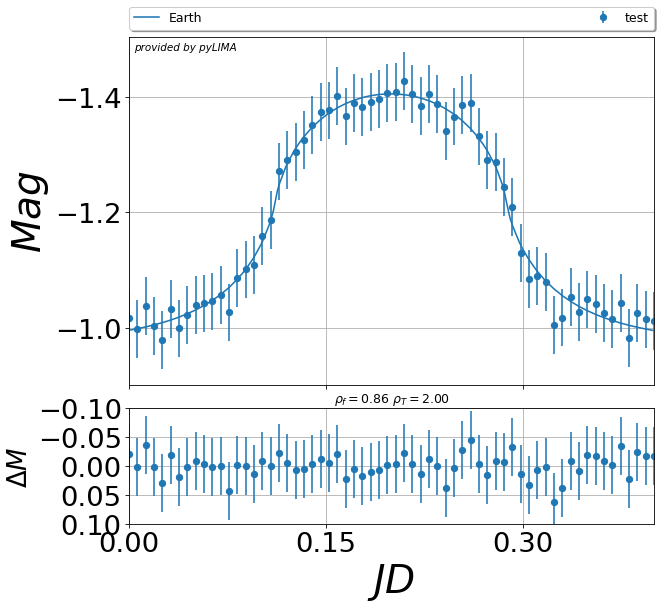

In [312]:
fig = pyLIMA_plots.plot_lightcurves(fspl, fspl_fit.fit_results['best_model'])
# fig = pyLIMA_plots.plot_lightcurves(fspl, guess_parameters)

plt.xlim(-2*tE+t0,2*tE+t0)
plt.title(r'$\rho_f = {:.2f}$'.format(fspl_fit.fit_results['best_model'][3]) + r' $\rho_T = {:.2f}$'.format(rho))
plt.show()

### MCMC

In [332]:
fspl_mcmc_fit = MCMC_fit.MCMCfit(fspl, MCMC_walkers=4, loss_function='chi2')
fspl_mcmc_fit.fit_parameters['rho'][1] = [0.0, 10]
fspl_mcmc_fit.fit_parameters['tE'][1] = (0.0, 2)
fspl_mcmc_fit.fit_parameters['u0'][1] = (0.0, rho)
# guess_parameters = [0.2, 0.3, 0.3, 2.5]
# fspl_mcmc_fit.model_parameters_guess = guess_parameters
#Initialize MCMC with best parameters of DE fit
fspl_mcmc_fit.model_parameters_guess = fspl_fit.fit_results['best_model']

fspl_mcmc_fit.fit()

initial_guess  : Initial parameters guess SUCCESS
Using guess:  [0.19934766233784817, 0.04348301863204562, 0.1018594094815568, 0.8645965236373563]


100%|██████████| 5000/5000 [00:13<00:00, 371.97it/s]


fit  : Monte Carlo Markov Chain (Affine Invariant) fit SUCCESS
best_model: [1.99322778e-01 4.91396296e-03 5.05638432e-02 1.78324578e+00
 2.02196277e+11 2.68316322e+10] chi2 -8.22110553197901


In [333]:
MCMC_results = fspl_mcmc_fit.fit_results['MCMC_chains']
print('Parameters', ' Model', '   Fit', '     Errors')
print('-----------------------------------')
print('t_0:', '        ' + str(t0)+'  ', str(np.median(MCMC_results[1000:, :, 0]))[:7], '',
      str(np.std(MCMC_results[1000:, :, 0]))[:7])
print('u_0:', '        ' + str(u0)+'  ', str(np.median(MCMC_results[1000:, :, 1]))[:7], '',
      str(np.std(MCMC_results[1000:, :, 1]))[:7])
print('t_E:', '        ' + str(tE)+'  ', str(np.median(MCMC_results[1000:, :, 2]))[:7], '',
      str(np.std(MCMC_results[1000:, :, 2]))[:7])
print('rho:', '        ' + str(rho)+'  ', str(np.median(MCMC_results[1000:, :, 3]))[:7], '',
      str(np.std(MCMC_results[1000:, :, 3]))[:7])

Parameters  Model    Fit      Errors
-----------------------------------
t_0:         0.2   0.19926  0.00150
u_0:         0.4   0.60651  0.56878
t_E:         0.1   0.05004  0.02476
rho:         2.0   1.96154  0.72011


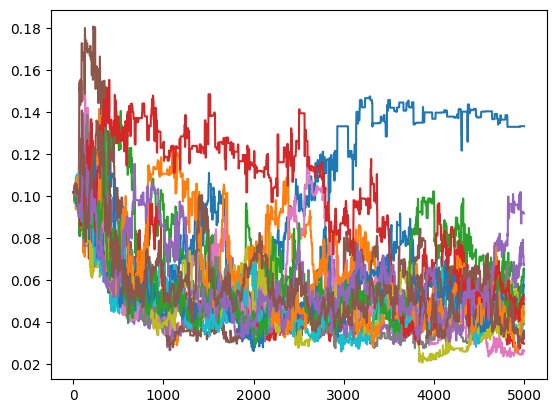

In [337]:
plt.plot(fspl_mcmc_fit.fit_results['MCMC_chains'][:,:,2])
plt.show()

In [335]:
burn_in = 1000
MCMC_results_pruned = MCMC_results[burn_in:, :, :]
reshaped_results = MCMC_results_pruned.reshape(-1, 5)

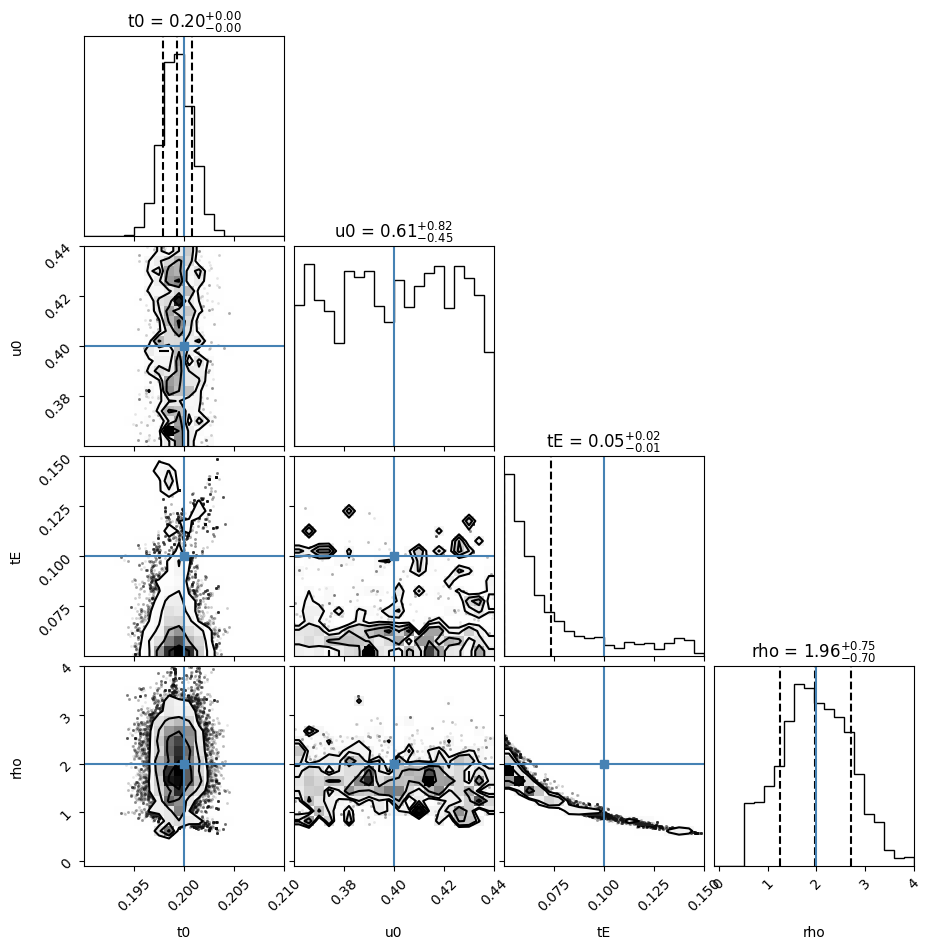

In [336]:
fspl_mcmc_fit.fit_parameters.keys()
figure = corner.corner(reshaped_results[:,0:4], labels=[label for label in fspl_mcmc_fit.fit_parameters.keys()],
                       quantiles=[0.16,0.5, 0.84], 
                       truths=[t0, u0, tE, rho], 
                       show_titles=True,
                       range=[(0.95*t0, 1.05*t0), (0.9*u0, 1.1*u0), (0.5*tE, 1.5*tE), (-0.1, 2*rho)]
                       )
